# Reference
https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

# Libraries

In [1]:
# Plot
import seaborn as sns

# Train test split
from sklearn.model_selection import train_test_split

# Transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Imputer, Encoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Scaler
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
# Custom modules
from utils.pipelinetools import Debug
from utils.plottools import plot_data

# Setup

In [3]:
import numpy as np
import pandas as pd
import os
from collections import Counter

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

random_seed = 42
np.random.seed(random_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

def save_fig(fig_id, image_path, tight_layout=True, fig_extension="png", resolution=None):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    if resolution != None:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        plt.savefig(path, format=fig_extension)

# Data Loading

In [4]:
DATA_PATH = "dataset/melb_data.csv"
df = pd.read_csv(DATA_PATH)

# Quick Look

In [5]:
df.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0


In [6]:
df.shape

(13580, 21)

In [7]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [8]:
# First step: pass data to imputer and remove coloum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [9]:
df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


Saving figure attribute_histogram_plots


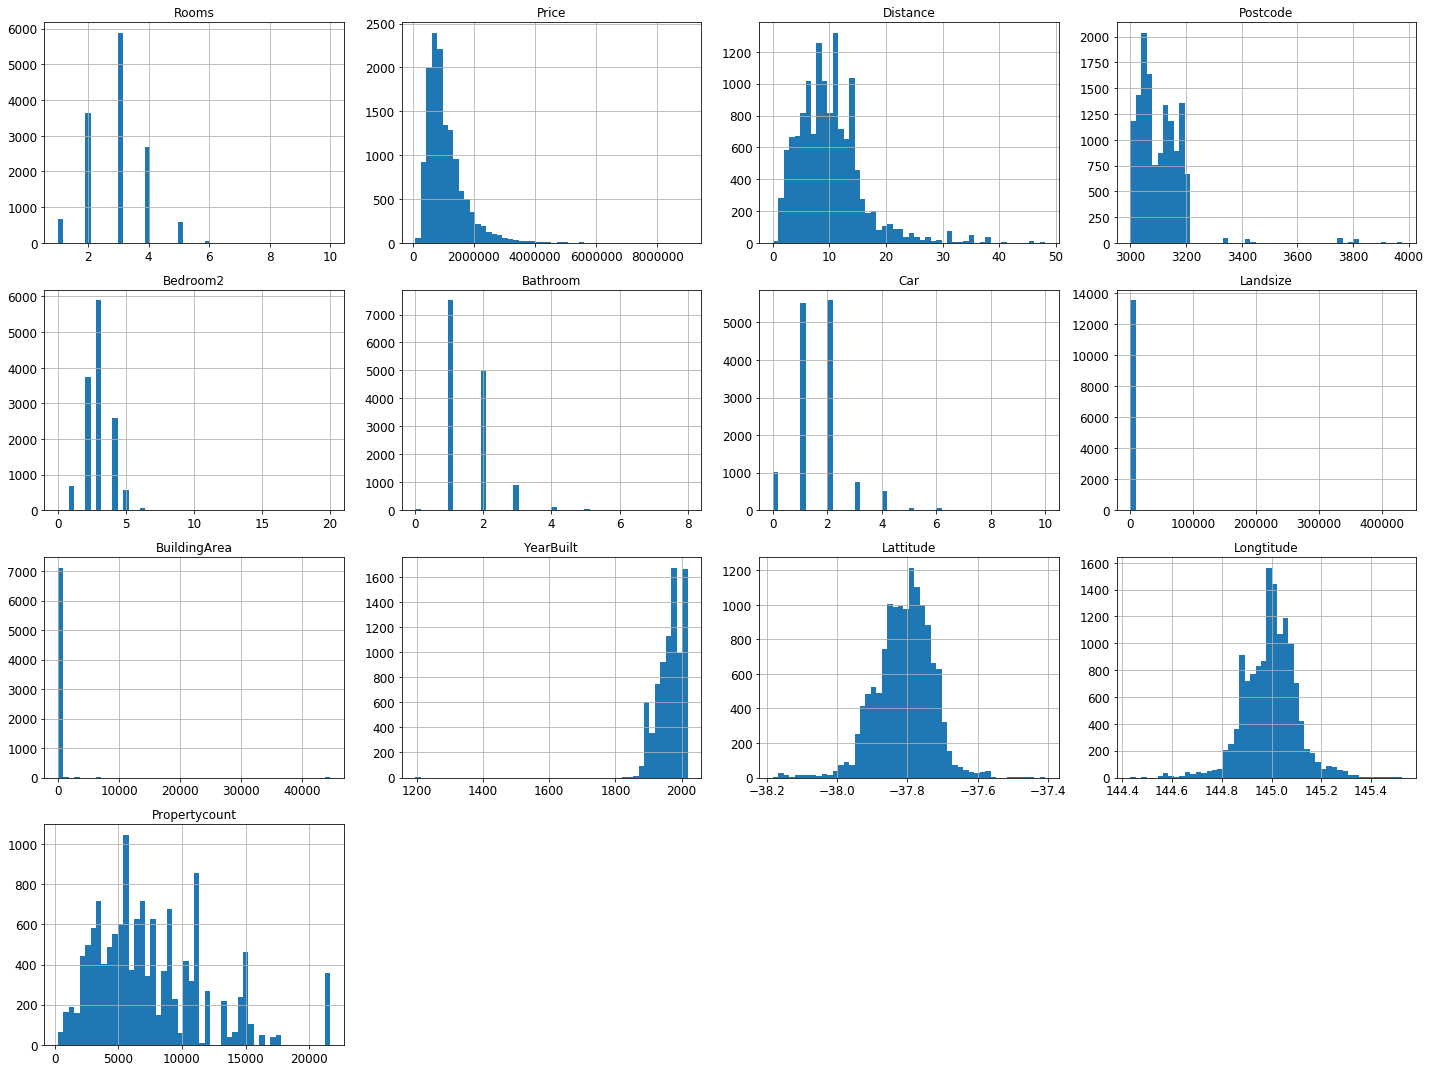

In [10]:
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots", IMAGES_PATH)
plt.show()

In [11]:
# plot_data(df, "hist", (4, 4), (20, 15))
# plot_data(df, "boxplot", (4, 4), (20, 15))

# Data Split

- Different types of train-test split

    1. Random shuffle split
    2. **Stratified shuffle split**

## Random Shuffle Split

In [12]:
# from sklearn.model_selection import train_test_split

# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## Stratified Shuffle Split

From previous section **"Quick Look"**, we observed that some feature columns have a clear distribution, eg. **"Distance"**. 

In order to have the **same data distribution** as the original data after split, we use **"StratifiedShuffleSplit"** class to preserve data distribution during split.

In [13]:
df.Distance.describe()

count    13580.000000
mean        10.137776
std          5.868725
min          0.000000
25%          6.100000
50%          9.200000
75%         13.000000
max         48.100000
Name: Distance, dtype: float64

In [14]:
BinnedCol = "DistanceBin"

# Binning 'Distance' column in order to perform Stratified Split
df[BinnedCol] = pd.cut(
    df['Distance'], 
    bins=[-1.0, 6., 12., 18., 24., np.inf], 
    labels=[1, 2, 3, 4, 5]
).astype('int')     # convert resulting dtype 'categorical' to 'int'

# train_clean.drop('dist_cat', inplace=True, axis=1)

In [15]:
df.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,DistanceBin
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0,1
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0,1


In [16]:
df[BinnedCol].value_counts()

2    6230
1    3260
3    3169
4     522
5     399
Name: DistanceBin, dtype: int64

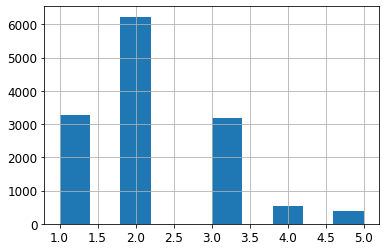

In [17]:
df.DistanceBin.hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)

for train_indices, test_indices in split.split(df, df[BinnedCol]):
    train = df.loc[train_indices]
    test = df.loc[test_indices]

10864


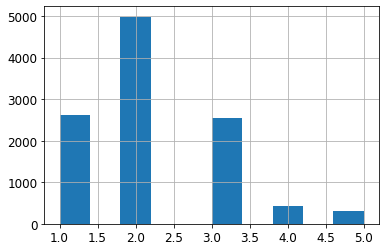

In [19]:
# verify that 'Distance' distribution indeed preserve after split
print(len(train))
train[BinnedCol].hist()

2716


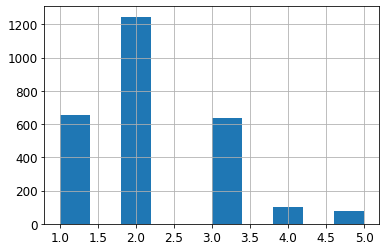

In [20]:
print(len(test))
test[BinnedCol].hist()

In [21]:
'''
Drop binning after data split since we only use binning for data split, 
but not creating new features here.

If we keep binning, there may be data leakage since test data set 
infomation is used to construct the binning in the train set.

If we want to use binning, we can do binning later only on train set.
'''

train.drop([BinnedCol], inplace=True, axis=1)
test.drop([BinnedCol], inplace=True, axis=1)

# Data Cleaning

## Imputer Transformer

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10864 entries, 350 to 8910
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         10864 non-null  object 
 1   Address        10864 non-null  object 
 2   Rooms          10864 non-null  int64  
 3   Type           10864 non-null  object 
 4   Price          10864 non-null  float64
 5   Method         10864 non-null  object 
 6   SellerG        10864 non-null  object 
 7   Date           10864 non-null  object 
 8   Distance       10864 non-null  float64
 9   Postcode       10864 non-null  float64
 10  Bedroom2       10864 non-null  float64
 11  Bathroom       10864 non-null  float64
 12  Car            10818 non-null  float64
 13  Landsize       10864 non-null  float64
 14  BuildingArea   5719 non-null   float64
 15  YearBuilt      6555 non-null   float64
 16  CouncilArea    9794 non-null   object 
 17  Lattitude      10864 non-null  float64
 18  Longt

In [23]:
# Columns that contains null value
def get_null_cols(data):
    return data.columns[data.count() != len(data)]

null_cols = get_null_cols(train)
null_cols

Index(['Car', 'BuildingArea', 'YearBuilt', 'CouncilArea'], dtype='object')

In [24]:
imp_num_continuous_colnames = ['BuildingArea']
imp_num_discrete_colnames = ['Car', 'YearBuilt']
imp_obj_colnames = ['CouncilArea']
imp_colnames = imp_num_continuous_colnames + imp_num_discrete_colnames + imp_obj_colnames

imputerColTrans = ColumnTransformer(
    [
        ('imp_num_continuous', SimpleImputer(strategy='median'), imp_num_continuous_colnames),
        ('imp_num_discrete', SimpleImputer(strategy='median'), imp_num_discrete_colnames),
        ('imp_object', SimpleImputer(strategy='most_frequent'), imp_obj_colnames),
    ],
    remainder='passthrough'
)

In [25]:
# Impute train to get train_clean

train_colnames = list(train.columns)
add_colnames = imp_colnames + [x for x in train_colnames if x not in imp_colnames]
add_colnames_index = train.index

train_clean = train.copy()
t = imputerColTrans.fit_transform(train)

for j, colname in enumerate(add_colnames):
    dtype = train_clean[colname].dtype
    train_clean[colname] = t[:, j]
    train_clean[colname] = train_clean[colname].astype(dtype)

In [26]:
# All columns have removed null values !!!
get_null_cols(train_clean)

Index([], dtype='object')

## AddColnamesTrans

In [27]:
from utils.pipelinetools import AddColnamesTrans

# class AddColnamesTrans(BaseEstimator, TransformerMixin):
#     def __init__(self, colnames):
#         self.colnames = colnames

#     def fit(self, X, y=None):
#         print('[AddColnames]: fit()')
#         return self
        
#     def transform(self, X, y=None):
#         print('[AddColnames]: transform()')
#         return pd.DataFrame(X, columns=self.colnames)

## Parsing Date Trans

In [28]:
date_colname = 'Date'
train_clean[date_colname]

350      26/07/2016
9570     17/06/2017
12492     9/09/2017
12570     9/09/2017
1410     12/06/2016
            ...    
7167      3/12/2016
11466    15/07/2017
9231      3/06/2017
1872     18/03/2017
8910      1/07/2017
Name: Date, Length: 10864, dtype: object

In [29]:
# Now DateParsed dtype is in 'datetime64', pandas can undetstand the parsed datetime now
train_clean['DateParsed'] = pd.to_datetime(train_clean[date_colname], format='%d/%m/%Y')
train_clean['DateParsed']

350     2016-07-26
9570    2017-06-17
12492   2017-09-09
12570   2017-09-09
1410    2016-06-12
           ...    
7167    2016-12-03
11466   2017-07-15
9231    2017-06-03
1872    2017-03-18
8910    2017-07-01
Name: DateParsed, Length: 10864, dtype: datetime64[ns]

In [30]:
train_clean['DateParsedYear'] = train_clean['DateParsed'].dt.year
train_clean['DateParsedMonth'] = train_clean['DateParsed'].dt.month

In [31]:
train_clean['DateParsedYear'], train_clean['DateParsedMonth']

(350      2016
 9570     2017
 12492    2017
 12570    2017
 1410     2016
          ... 
 7167     2016
 11466    2017
 9231     2017
 1872     2017
 8910     2017
 Name: DateParsedYear, Length: 10864, dtype: int64,
 350       7
 9570      6
 12492     9
 12570     9
 1410      6
          ..
 7167     12
 11466     7
 9231      6
 1872      3
 8910      7
 Name: DateParsedMonth, Length: 10864, dtype: int64)

In [32]:
train_clean.drop(['Date'], axis=1, inplace=True)
train_clean.drop(['DateParsed'], axis=1, inplace=True)

In [33]:
from utils.pipelinetools import ParseDateTrans

# class ParseDateTrans(BaseEstimator, TransformerMixin):
#     def __init__(self, date_colname):
#         self.date_colname = date_colname
        
#     def fit(self, X, y = None):
#         print('[ParseDateTrans]: fit()')
#         return self
    
#     def transform(self, X, y = None):
#         ### Do not change this ###
#         print('[ParseDateTrans]: transform()')

#         X_ = X.copy()
#         if isinstance(X, pd.Series):    # Convert Series to Dataframe
#             print('[ParseDateTrans]: Converting pandas series to dataframe')
#             X_ = X_.to_frame()    
#         ### Do not change this ###

#         X_['DateParsed'] = pd.to_datetime(X_[self.date_colname], format='%d/%m/%Y')
#         X_['DateParsedYear'] = X_['DateParsed'].dt.year
#         X_['DateParsedMonth'] = X_['DateParsed'].dt.month
        
#         X_.drop(['Date', 'DateParsed'], axis=1, inplace=True)
#         return X_

## Astype Transformer

In [34]:
train_clean.dtypes

Suburb              object
Address             object
Rooms                int64
Type                object
Price              float64
Method              object
SellerG             object
Distance           float64
Postcode           float64
Bedroom2           float64
Bathroom           float64
Car                float64
Landsize           float64
BuildingArea       float64
YearBuilt          float64
CouncilArea         object
Lattitude          float64
Longtitude         float64
Regionname          object
Propertycount      float64
DateParsedYear       int64
DateParsedMonth      int64
dtype: object

In [35]:
from utils.pipelinetools import AstypeTrans

# class AstypeTrans(BaseEstimator, TransformerMixin):
#     def __init__(self, col_type_dict={}):
#         self.col_type_dict = col_type_dict
        
#     def fit(self, X, y = None):
#         print('[AstypeTrans]: fit()')
#         return self
    
#     def transform(self, X, y = None):
#         ### Do not change this ###
#         print('[AstypeTrans]: transform()')
        
#         X_ = X.copy()
#         if isinstance(X, pd.Series):    # Convert Series to Dataframe
#             print('[AstypeTrans]: Converting pandas series to dataframe')
#             X_ = X_.to_frame()    
#         ### Do not change this ###

#         for key, val in self.col_type_dict.items():
#             X_[key] =  X_[key].astype(val)

#         return X_

In [36]:
col_type_dict = {
    'Bedroom2': 'int',
    'Bathroom': 'int',
    'Car': 'int',
    'YearBuilt': 'int',
    'Propertycount': 'int',    
    'BuildingArea': 'float',    
}

train_clean = AstypeTrans(col_type_dict=col_type_dict).fit_transform(train_clean)
train_clean.dtypes

[AstypeTrans]: fit()
[AstypeTrans]: transform()


Suburb              object
Address             object
Rooms                int64
Type                object
Price              float64
Method              object
SellerG             object
Distance           float64
Postcode           float64
Bedroom2             int64
Bathroom             int64
Car                  int64
Landsize           float64
BuildingArea       float64
YearBuilt            int64
CouncilArea         object
Lattitude          float64
Longtitude         float64
Regionname          object
Propertycount        int64
DateParsedYear       int64
DateParsedMonth      int64
dtype: object

In [37]:
train_clean.dtypes

Suburb              object
Address             object
Rooms                int64
Type                object
Price              float64
Method              object
SellerG             object
Distance           float64
Postcode           float64
Bedroom2             int64
Bathroom             int64
Car                  int64
Landsize           float64
BuildingArea       float64
YearBuilt            int64
CouncilArea         object
Lattitude          float64
Longtitude         float64
Regionname          object
Propertycount        int64
DateParsedYear       int64
DateParsedMonth      int64
dtype: object

## Data Cleaning Pipeline

Create **data cleaning pipeline** for later use. It is one of the component in **full_pipeline**

In [38]:
col_type_dict = {
    'Rooms': 'int',
    'Bedroom2': 'int',
    'Bathroom': 'int',
    'Car': 'int',
    'YearBuilt': 'int',
    'Propertycount': 'int',  
    'Price': 'float',
    'Distance': 'float',
    'Postcode': 'float',
    'Landsize': 'float',
    'BuildingArea': 'float',    
    'Lattitude': 'float',    
    'Longtitude': 'float',    
}

date_colname = 'Date'
train_colnames = list(train.columns)
add_colnames = imp_colnames + [x for x in train_colnames if x not in imp_colnames]
# add_colnames_index = train.index

In [39]:
cleanPipe = Pipeline([
    ('imputerColTrans', imputerColTrans),
    ('addColnamesTrans', AddColnamesTrans(add_colnames)),
    ('dateParserTrans', ParseDateTrans(date_colname)),
    ('astypeTrans', AstypeTrans(col_type_dict)),
])

In [40]:
train_clean = cleanPipe.fit_transform(train)
train_clean

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()


,BuildingArea,Car,YearBuilt,CouncilArea,Suburb,Address,Rooms,Type,Price,Method,...,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Regionname,Propertycount,DateParsedYear,DateParsedMonth
0,172.0,2,2011,Moonee Valley,Ascot Vale,25 Dalgety Dr,3,h,940000.0,S,...,3032.0,3,2,285.0,-37.77780,144.90610,Western Metropolitan,6567,2016,7
1,126.0,2,1970,Bayside,Hampton,10/78 Holyrood St,2,u,805000.0,S,...,3188.0,2,1,0.0,-37.93387,145.00227,Southern Metropolitan,5454,2017,6
2,148.0,2,1970,Moreland,Epping,11 Northumberland Dr,3,h,641000.0,S,...,3076.0,3,2,535.0,-37.64372,145.03761,Northern Metropolitan,10926,2017,9
3,126.0,2,2005,Moreland,Newport,211A Woods St,4,h,980000.0,SP,...,3015.0,4,3,622.0,-37.84471,144.86594,Western Metropolitan,5498,2017,9
4,126.0,1,2002,Moreland,Brunswick West,18/180 Union St,2,u,435000.0,S,...,3055.0,2,1,0.0,-37.77270,144.94970,Northern Metropolitan,7082,2016,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,126.0,1,1970,Glen Eira,Ormond,21 Tyrone St,2,h,1960000.0,S,...,3204.0,2,1,719.0,-37.90710,145.04600,Southern Metropolitan,3578,2016,12
10860,126.0,2,1970,Moreland,Oak Park,4 School Ct,4,h,1453000.0,S,...,3046.0,4,2,525.0,-37.71467,144.92528,Northern Metropolitan,2651,2017,7
10861,129.0,2,1980,Kingston,Mentone,70 Voltri St,3,h,885000.0,S,...,3194.0,3,1,530.0,-37.97584,145.08107,South-Eastern Metropolitan,6162,2017,6
10862,88.0,2,1970,Monash,Chadstone,7 Inga Ct,3,h,1301000.0,S,...,3148.0,3,1,620.0,-37.88120,145.10500,Southern Metropolitan,3582,2017,3


# Data Analysis

## Outliers

### Distributions

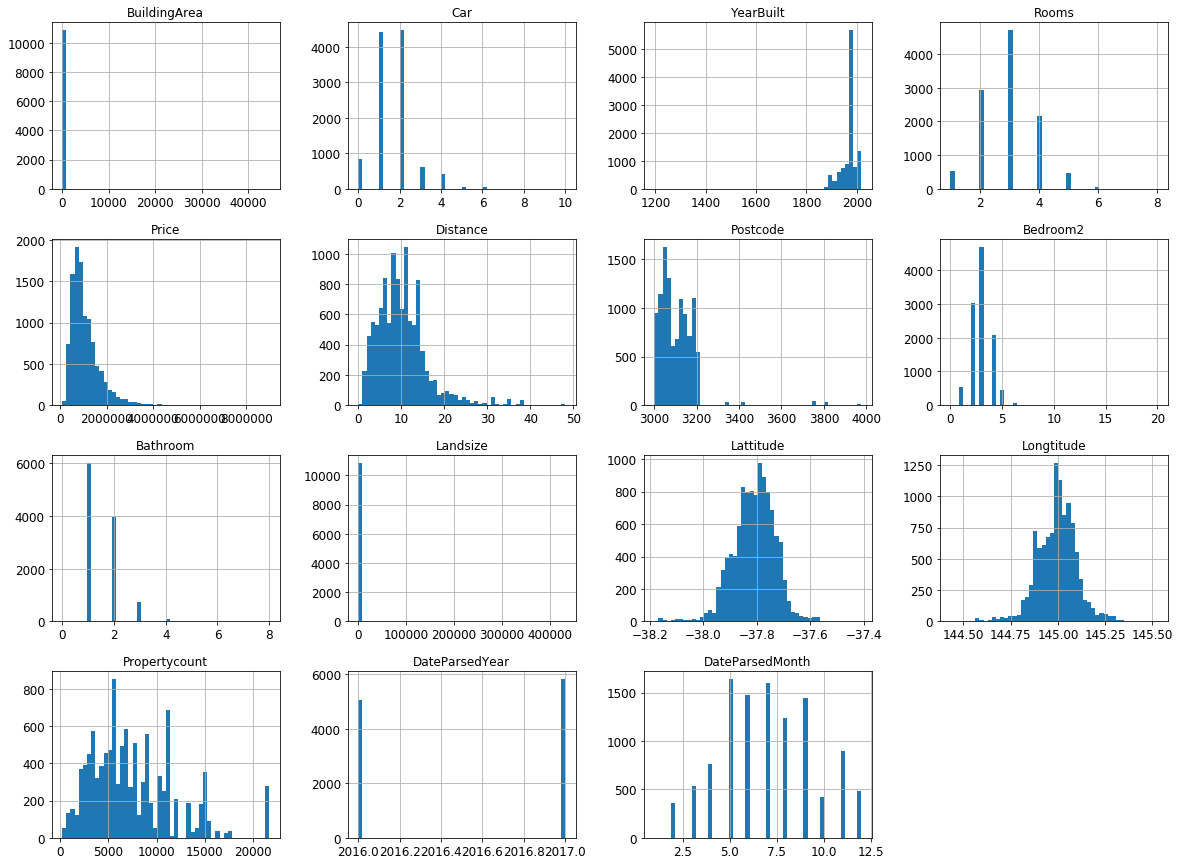

In [41]:
train_clean.hist(bins=50, figsize=(20, 15))
plt.show()

### 'Landsize' Binning

In [42]:
# There are extreme outliers having very large value, either delete them or use binning
train_clean.Landsize.describe()

count     10864.000000
mean        566.235825
std        4434.097641
min           0.000000
25%         173.000000
50%         436.000000
75%         650.000000
max      433014.000000
Name: Landsize, dtype: float64

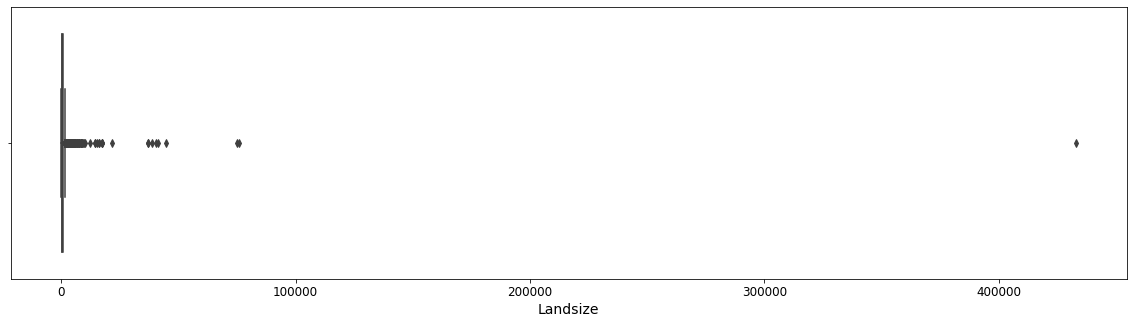

In [43]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='Landsize', data=train_clean)

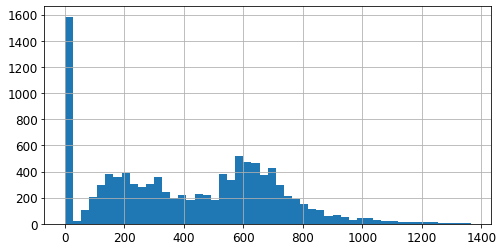

In [44]:
from utils.analytools import handle_outliers 

# def handle_outliers(
#     data,
#     cols=[],
#     method="capping",
#     lower_quantile=0.25,
#     upper_quantile=0.75,
#     whisker_width=1.5,
# ):
#     data_clean = data.copy()

#     for col in cols:
#         q1 = data_clean[col].quantile(lower_quantile)
#         q3 = data_clean[col].quantile(upper_quantile)
#         iqr = q3 - q1

#         lower_whisker = q1 - whisker_width * iqr
#         upper_whisker = q3 + whisker_width * iqr

#         if method == "cap":
#             data_clean[col] = np.where(
#                 data[col] > upper_whisker,
#                 upper_whisker,
#                 np.where(data[col] < lower_whisker, lower_whisker, data[col]),
#             )
#         elif method == "drop":
#             data_clean = data_clean.drop(
#                 data_clean[
#                     (data_clean[col] < lower_whisker)
#                     | (data_clean[col] > upper_whisker)
#                 ].index
#             )

#     return data_clean

t = handle_outliers(
    train_clean,
    cols=['Landsize'],
    method='drop'
)

t.Landsize.hist(bins=50, figsize=(8, 4))

In [45]:
t.Landsize[t.Landsize < 28.6].count()

1585

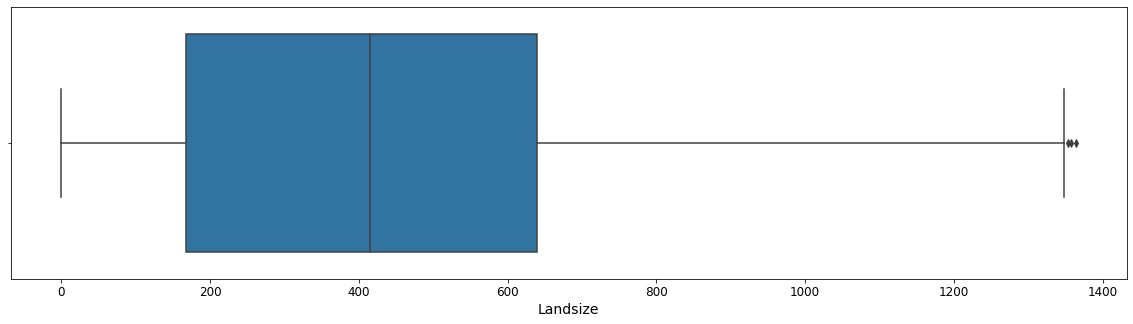

In [46]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='Landsize', data=t)

**Here we are not going to drop outliers, but using binning to reduce the effect of outliers**

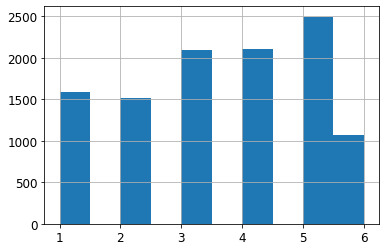

In [47]:
t = train_clean.copy()

t['LandsizeBin'] = pd.cut(
    t['Landsize'],
    bins=[-1., 20., 200., 400., 600., 800., np.inf],
    labels=[1, 2, 3, 4, 5, 6]
)

t.LandsizeBin.hist()

### 'BuildingArea' binning

In [48]:
bin_col = 'BuildingArea'

In [49]:
train_clean[bin_col].describe()

count    10864.000000
mean       139.636863
std        431.248500
min          0.000000
25%        122.000000
50%        126.000000
75%        130.000000
max      44515.000000
Name: BuildingArea, dtype: float64

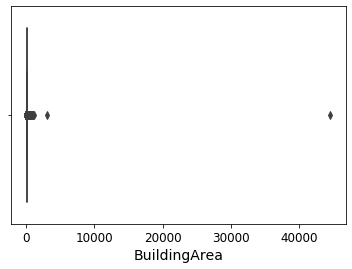

In [50]:
sns.boxplot(x=bin_col, data=train_clean)

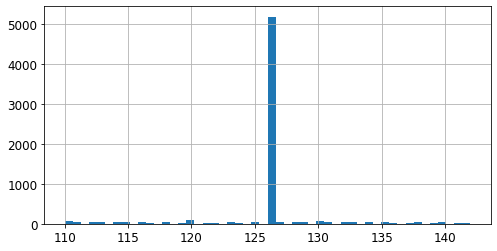

In [51]:
t = handle_outliers(
    train_clean,
    cols=[bin_col],
    method='drop'
)

t[bin_col].hist(bins=50, figsize=(8, 4))

## !!! 'BuildingArea' count seems weird at value '126', 
## since more than half of entries are imputed using median

## I decide to drop this column due to a lot of missing values 
## and inappropriate imputing values

### Binning Transformers

In [52]:
from utils.pipelinetools import DataBinning

# class DataBinning(BaseEstimator, TransformerMixin):
#     def __init__(self, bin_info=None):
#         self.bin_info = bin_info

#     def fit(self, X, y=None):
#         print('[DataBinning]: fit()')
#         if self.bin_info == None:
#             print('[DataBinning]: auto binning...')
#         return self

#     def transform(self, X, y=None):
#         print('[DataBinning]: transform()')
#         X_ = X.copy()
        
#         for colname, bins, labels, dtype in self.bin_info:
#             X_[f'{colname}Bin'] = pd.cut(
#                 X_[colname], 
#                 bins=bins, 
#                 labels=labels
#             ).astype(dtype)
#             X_.drop([colname], axis=1, inplace=True)

#         return X_

In [53]:
bin_info = (
    ('Landsize', [-1., 20., 200., 400., 600., 800., np.inf], [1, 2, 3, 4, 5, 6], 'int'),
)

dataBinning = DataBinning(bin_info)
t = dataBinning.fit_transform(train_clean)

[DataBinning]: fit()
[DataBinning]: transform()


In [54]:
t.head()

,BuildingArea,Car,YearBuilt,CouncilArea,Suburb,Address,Rooms,Type,Price,Method,...,Postcode,Bedroom2,Bathroom,Lattitude,Longtitude,Regionname,Propertycount,DateParsedYear,DateParsedMonth,LandsizeBin
0,172.0,2,2011,Moonee Valley,Ascot Vale,25 Dalgety Dr,3,h,940000.0,S,...,3032.0,3,2,-37.77780,144.90610,Western Metropolitan,6567,2016,7,3
1,126.0,2,1970,Bayside,Hampton,10/78 Holyrood St,2,u,805000.0,S,...,3188.0,2,1,-37.93387,145.00227,Southern Metropolitan,5454,2017,6,1
2,148.0,2,1970,Moreland,Epping,11 Northumberland Dr,3,h,641000.0,S,...,3076.0,3,2,-37.64372,145.03761,Northern Metropolitan,10926,2017,9,4
3,126.0,2,2005,Moreland,Newport,211A Woods St,4,h,980000.0,SP,...,3015.0,4,3,-37.84471,144.86594,Western Metropolitan,5498,2017,9,5
4,126.0,1,2002,Moreland,Brunswick West,18/180 Union St,2,u,435000.0,S,...,3055.0,2,1,-37.77270,144.94970,Northern Metropolitan,7082,2016,6,1


In [55]:
# Transform train_clean when all things are fine
train_clean = dataBinning.fit_transform(train_clean)

[DataBinning]: fit()
[DataBinning]: transform()


## Visualizing Geographical Data

Saving figure bad_geo_plot


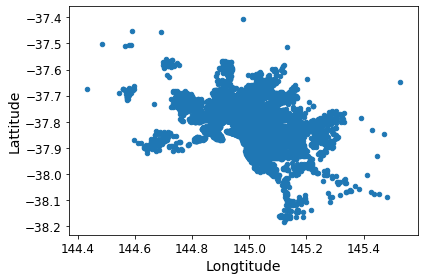

In [56]:
train_clean.plot(kind='scatter', x='Longtitude', y='Lattitude')
save_fig('bad_geo_plot', IMAGES_PATH)

Saving figure price_location_scatterplot


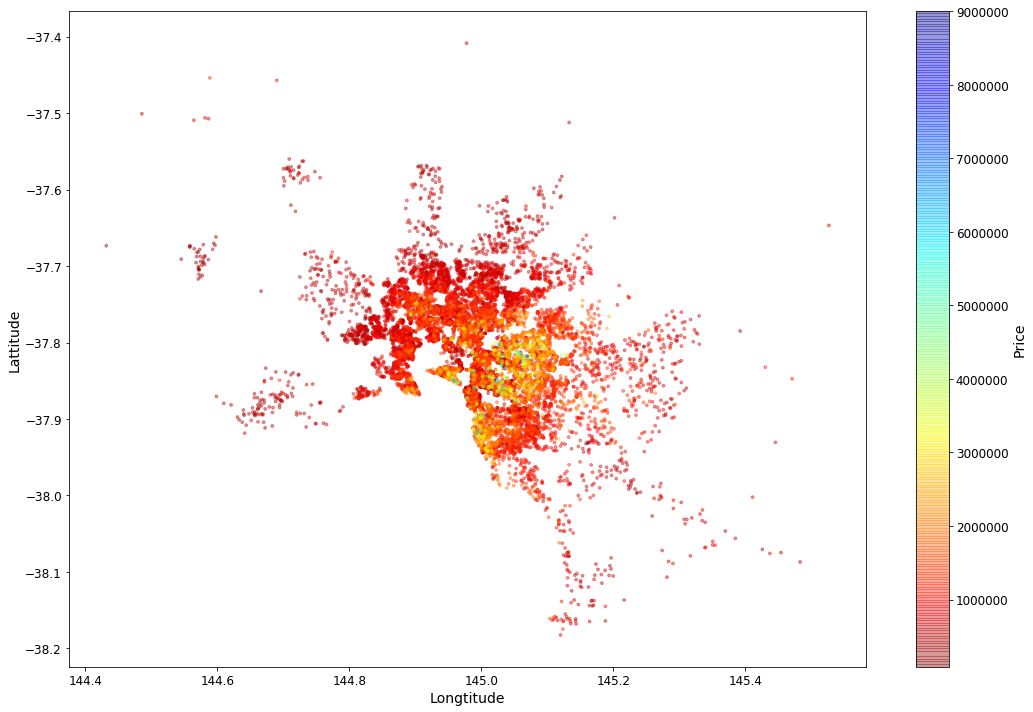

In [57]:
# Notes: sort Price in ascending order so that data point with higher price 
# will be plot on top of data point with lower price, since amount of data 
# point with higher price are much fewer that of lower price

train_clean.sort_values(by=['Price']).plot(
    kind="scatter", 
    x="Longtitude", 
    y="Lattitude", 
    alpha=0.4,
    s=8,
    figsize=(15,10),
    c="Price", 
    cmap=plt.get_cmap("jet").reversed(),   # reverse colormap so that darker color represents higher price
    colorbar=True, 
    sharex=False
)

save_fig('price_location_scatterplot', IMAGES_PATH)

## Correlations

In [58]:
corr = train_clean.corr()

In [59]:
corr['Price'].sort_values(ascending=False)

Price              1.000000
Rooms              0.499161
Bedroom2           0.475390
Bathroom           0.465543
LandsizeBin        0.313103
Car                0.223661
Longtitude         0.202839
Postcode           0.111325
BuildingArea       0.064286
DateParsedMonth    0.031571
DateParsedYear     0.001665
Propertycount     -0.040004
Distance          -0.164914
Lattitude         -0.213723
YearBuilt         -0.259703
Name: Price, dtype: float64

(15.0, 0.0)

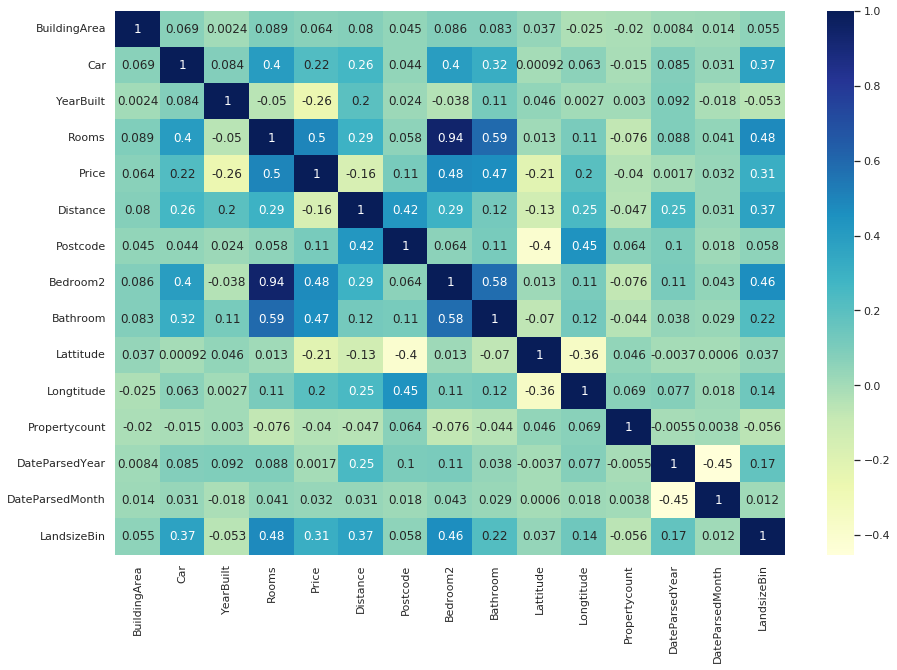

In [60]:
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, annot_kws={"fontsize":12})

# For fixing "first and last row cut in half of heatmap plot" bug
# Its a bug in the matplotlib regression between 3.1.0 and 3.1.1
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# save_fig("corr_matrix", IMAGES_PATH)

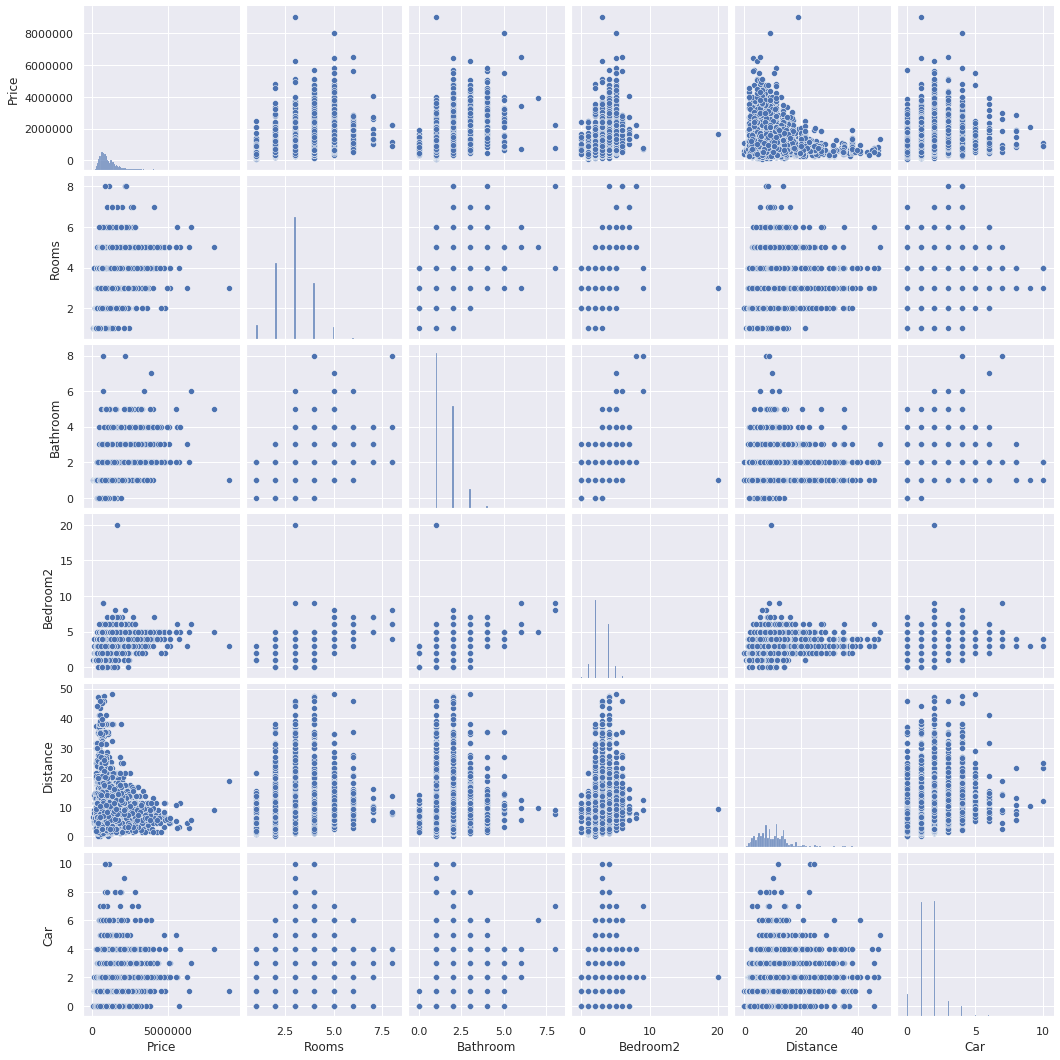

In [61]:
high_corr_feats = ['Price', 'Rooms', 'Bathroom', 'Bedroom2', 'Distance', 'Car']
sns.pairplot(train_clean[high_corr_feats])

In [62]:
print(train_clean.CouncilArea.nunique())
print(train_clean.Regionname.nunique())

33
8


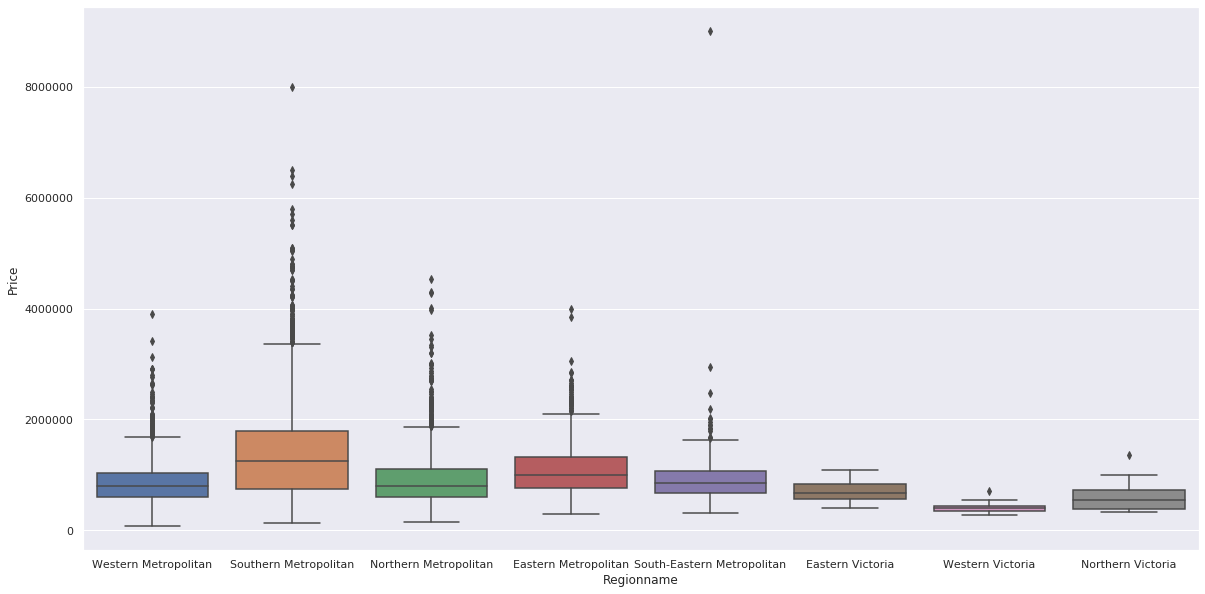

In [63]:
'''
Group df data by councilArea and Regionname.
Investigate price pattern comparing different districts.
'''

# # Method 1: create new column
# train_clean['CA_median_price'] = (train_clean.groupby("CouncilArea")["Price"].transform("median"))
# train_clean['RN_median_price'] = (train_clean.groupby('Regionname')['Price'].transform('median'))
# # train_clean.drop(['CA_median_price', 'RN_median_price'], axis=1, inplace=True)

# Method 2: sns.boxplot()
plt.figure(figsize=(20, 10))
sns.boxplot(x='Regionname', y='Price', data=train_clean)

## Mutual Information (MI)

In [64]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    # discrete_features: boolean mask that indicate which features are discrete, then the ramaining is continuous
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores   # same shape as X.shape[0]

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [65]:
X = train_clean.drop(["Price"], axis=1)
y = train_clean['Price']

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [66]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

Address            1.549186
Suburb             0.401960
Propertycount      0.395201
Postcode           0.307897
Rooms              0.214478
Bedroom2           0.203324
BuildingArea       0.192466
Distance           0.191684
CouncilArea        0.179694
Type               0.174195
SellerG            0.167001
Longtitude         0.147985
Lattitude          0.147860
Bathroom           0.131906
LandsizeBin        0.118614
Method             0.110415
Regionname         0.104511
Car                0.102273
YearBuilt          0.077176
DateParsedMonth    0.017616
DateParsedYear     0.000068
Name: MI Scores, dtype: float64

## Experimenting with Attribute Combinations

In [67]:
for col in list(train_clean.select_dtypes(include=['object'])):
    print(train_clean[col].value_counts())
    print('------------------------------')

Moreland             2010
Boroondara            925
Moonee Valley         793
Darebin               740
Glen Eira             669
Stonnington           573
Maribyrnong           559
Port Phillip          526
Yarra                 525
Banyule               470
Bayside               387
Melbourne             378
Hobsons Bay           348
Brimbank              339
Monash                265
Whitehorse            254
Manningham            244
Kingston              166
Whittlesea            135
Hume                  135
Wyndham                69
Knox                   67
Maroondah              66
Melton                 53
Greater Dandenong      46
Frankston              42
Casey                  29
Nillumbik              28
Yarra Ranges           10
Cardinia                8
Macedon Ranges          3
Unavailable             1
Moorabool               1
Name: CouncilArea, dtype: int64
------------------------------
Reservoir         279
Richmond          201
Bentleigh East    198
Preston      

In [68]:
from utils.pipelinetools import AddDropFeatBase
from utils.pipelinetools import AddDropFeat

# class AddDropFeatBase(BaseEstimator, TransformerMixin):
#     def __init__(self, add_colnames, del_colnames):
#         self.add_colnames = add_colnames
#         self.del_colnames = del_colnames

#     def fit(self, X, y=None):
#         return self
    
#     def drop_cols(self, X):
#         X.drop(self.del_colnames, axis=1, inplace=True)
    
#     def transform(self, X, y=None):
#         raise NotImplementedError("Please rewrite [AddDropFeatBase] transform method!")


# class AddDropFeat(AddDropFeatBase):
#     def __init__(self, add_colnames=None, del_colnames=None):
#         AddDropFeatBase.__init__(self, add_colnames, del_colnames)
#         self.add_colnames = add_colnames
#         self.del_colnames = del_colnames

#     def fit(self, X, y=None):
#         print('[AddDropFeat]: fit()')
#         return self

#     def transform(self, X): 
#         print('[AddDropFeat]: transform()')
#         X_ = X.copy()

#         self.drop_cols(X_)
#         return X_

In [69]:
del_colnames = [
    'BuildingArea',
    'Address',
    'Postcode',
    'DateParsedMonth',
    'DateParsedYear',
    'Propertycount',
    'Distance',
]

train_clean = AddDropFeat(del_colnames=del_colnames).fit_transform(train_clean)

[AddDropFeat]: fit()
[AddDropFeat]: transform()


## Feature Pipelines

In [70]:
bin_info = (
    ('Landsize', [-1., 20., 200., 400., 600., 800., np.inf], [1, 2, 3, 4, 5, 6], 'int'),
)

'''
'CouncilArea',
'Suburb',
'SellerG',

'Type',
'Method',

'Lattitude',
'Longtitude',
'''
del_colnames = [
    'Price',    # drop label here
    'BuildingArea',
    'Address',
    'Postcode',
    'DateParsedMonth',
    'DateParsedYear',
    'Propertycount',
    'Distance',
]

featPipe = Pipeline([
    ('dataBinningTrans', DataBinning(bin_info=bin_info)),
    ('addDropFeatTrans', AddDropFeat(del_colnames=del_colnames)),
])

# Encoders

## Object / Categorical Trans

### High Card Trans

In [71]:
from utils.pipelinetools import HighCardAggregation

In [72]:
# def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
#     #Find the threshold value using the percentage and number of instances in the column
#     threshold_value=int(threshold*len(column))
#     #Initialise an empty list for our new minimised categories
#     categories_list=[]
#     #Initialise a variable to calculate the sum of frequencies
#     s=0
#     #Create a counter dictionary of the form unique_value: frequency
#     counts=Counter(column)

#     #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
#     for i,j in counts.most_common():
#         #Add the frequency to the global sum
#         s+=dict(counts)[i]
#         #Append the category name to the list
#         categories_list.append(i)
#         #Check if the global sum has reached the threshold value, if so break the loop
#         if s>=threshold_value:
#             break
#     #Append the category Other to the list
#     categories_list.append('Other')

#     #Replace all instances not in our new categories by Other  
#     new_column=column.apply(lambda x: x if x in categories_list else 'Other')

#     #Return transformed column and unique values if return_categories=True
#     if(return_categories_list):
#         return new_column,categories_list
#     #Return only the transformed column if return_categories=False
#     else:
#         return new_column


# class HighCardAggregation(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y = None):
#         print('[HighCardAggregation]: fit()')
#         return self

#     def transform(self, X, y = None):
#         print('[HighCardAggregation]: transform()')
#         X_ = X.copy()
                
#         for col in list(X_.columns):
#             X_[col], trans_list = cumulatively_categorise(column=X_[col], threshold=0.75)

#         return X_

## Transformers

In [73]:
cat_obj_colnames = list(train_clean.select_dtypes('object'))

low_card_colnames = [col for col in cat_obj_colnames if train_clean[col].nunique() < 10]
print('low_card_colnames: ', low_card_colnames)

high_card_colnames = [col for col in cat_obj_colnames if train_clean[col].nunique() >= 10]
print('high_card_colnames: ', high_card_colnames)

low_card_colnames:  ['Type', 'Method', 'Regionname']
high_card_colnames:  ['CouncilArea', 'Suburb', 'SellerG']


In [74]:
# # Numerical transformer
# num_trans = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('std_scaler', StandardScaler())
# ])

lowCardPipe = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('ordinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

highCardPipe = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('aggregation', HighCardAggregation()),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('ordinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

encoderTrans = ColumnTransformer(
    transformers=[
#         ('num', num_trans, num_colnames),
        ('low_card_pipeline', lowCardPipe, low_card_colnames),
        ('high_card_pipeline', highCardPipe, high_card_colnames),
    ],
    remainder='passthrough'
)

In [75]:
t = encoderTrans.fit_transform(train_clean.copy())

[HighCardAggregation]: fit()
[HighCardAggregation]: transform()


# Pipeline

In [76]:
preprocessor = Pipeline([
    ('pre_clean', cleanPipe),
#     ('pre_debug_clean', Debug('pre_debug_clean')),
    ('pre_feat', featPipe),
#     ('pre_debug_feat', Debug('pre_debug_feat')),
    ('pre_encoder', encoderTrans),
#     ('pre_debug_encoder', Debug('pre_debug_encoder')),
    ('pre_scaler', StandardScaler()),
])

fullPipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=50, random_state=42)),
])

In [77]:
preprocessor.fit_transform(train)

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()
[DataBinning]: fit()
[DataBinning]: transform()
[AddDropFeat]: fit()
[AddDropFeat]: transform()
[HighCardAggregation]: fit()
[HighCardAggregation]: transform()


array([[-0.63413019, -0.36414483,  1.10355644, ...,  0.39810784,
        -0.86040091, -0.33132972],
       [ 1.76419545, -0.36414483,  0.61050507, ..., -1.57912915,
         0.065141  , -1.60799797],
       [-0.63413019, -0.36414483, -0.86864904, ...,  2.09675547,
         0.40525384,  0.3070044 ],
       ...,
       [-0.63413019, -0.36414483,  0.1174537 , ..., -2.11084336,
         0.8235137 ,  0.3070044 ],
       [-0.63413019, -0.36414483,  0.61050507, ..., -0.91185759,
         1.05381648,  0.94533852],
       [-0.63413019, -1.26019679,  0.61050507, ..., -1.26405333,
         1.20385494,  1.58367265]])

# Model

## Demo Predictions

### Predictions

In [78]:
y_train = train['Price']
y_test = test['Price']

In [79]:
train_preprocessed = preprocessor.fit_transform(train)

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()
[DataBinning]: fit()
[DataBinning]: transform()
[AddDropFeat]: fit()
[AddDropFeat]: transform()
[HighCardAggregation]: fit()
[HighCardAggregation]: transform()


In [80]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(train_preprocessed, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [81]:
test_preprocessed = preprocessor.transform(test)
y_preds = model.predict(test_preprocessed)

[AddColnames]: transform()
[ParseDateTrans]: transform()
[AstypeTrans]: transform()
[DataBinning]: transform()
[AddDropFeat]: transform()
[HighCardAggregation]: transform()


In [82]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
rmse

301600.49865898606

### FullPipeline with Predictor Predictions

In [83]:
fullPipe.fit(train, y_train)
full_y_preds = fullPipe.predict(test)

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()
[DataBinning]: fit()
[DataBinning]: transform()
[AddDropFeat]: fit()
[AddDropFeat]: transform()
[HighCardAggregation]: fit()
[HighCardAggregation]: transform()
[AddColnames]: transform()
[ParseDateTrans]: transform()
[AstypeTrans]: transform()
[DataBinning]: transform()
[AddDropFeat]: transform()
[HighCardAggregation]: transform()


In [84]:
fullPipe.score(test, y_test)

[AddColnames]: transform()
[ParseDateTrans]: transform()
[AstypeTrans]: transform()
[DataBinning]: transform()
[AddDropFeat]: transform()
[HighCardAggregation]: transform()


0.7760243554430747

## Model Loading

In [85]:
import joblib
import os
if os.path.isfile('models/forest_reg.pkl'):
    global forest_reg
    forest_reg = joblib.load('models/forest_reg.pkl')
    print('Load Successfull!')

Load Successfull!


## Different Models

In [86]:
from utils.modeltools import fine_tune_models
from utils.modeltools import compare_baseline_models

In [87]:
models = {
    'lr': [
        LinearRegression(),
        None,
    ],
#     'logistic': [
#         LogisticRegression(),
#         {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
#     ],
    'ridge': [
        Ridge(),
        None,
    ],
    'forest': [
        RandomForestRegressor(),
        [
            # try 12 (3×4) combinations of hyperparameters
            {'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8, 10]},
            # then try 6 (2×3) combinations with bootstrap set as False
            {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 6]},
        ],
    ],
}

In [88]:
compare_baseline_models(train, test, "Price", preprocessor, models) 

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()
[DataBinning]: fit()
[DataBinning]: transform()
[AddDropFeat]: fit()
[AddDropFeat]: transform()
[HighCardAggregation]: fit()
[HighCardAggregation]: transform()
[AddColnames]: transform()
[ParseDateTrans]: transform()
[AstypeTrans]: transform()
[DataBinning]: transform()
[AddDropFeat]: transform()
[HighCardAggregation]: transform()
Evaluating [lr] ...

Params: 
 <bound method BaseEstimator.get_params of LinearRegression()>

Metrics:
test MSE =  225650208733.6926
train accuracy :  [0.45166572 0.4343737  0.45924447 0.45963423 0.49400851]
test accuracy :  [0.46058132 0.41147967 0.46739319 0.42624161 0.44616583]
time elapsed :  1.351064920425415
Evaluating [ridge] ...

Params: 
 <bound method BaseEstimator.get_params of Ridge()>

Metrics:
test MSE =  225650004575.3377
train accuracy :  [0.45166584 0.43437712 0.45924319 0.45964133 0.49400773]
t

In [89]:
fine_tune_models(train, test, "Price", preprocessor, models) 

[AddColnames]: fit()
[AddColnames]: transform()
[ParseDateTrans]: fit()
[ParseDateTrans]: transform()
[AstypeTrans]: fit()
[AstypeTrans]: transform()
[DataBinning]: fit()
[DataBinning]: transform()
[AddDropFeat]: fit()
[AddDropFeat]: transform()
[HighCardAggregation]: fit()
[HighCardAggregation]: transform()
[AddColnames]: transform()
[ParseDateTrans]: transform()
[AstypeTrans]: transform()
[DataBinning]: transform()
[AddDropFeat]: transform()
[HighCardAggregation]: transform()
Fine-tunning [lr] ...

time elapsed :  4.76837158203125e-07
Fine-tunning [ridge] ...

time elapsed :  0.0
Fine-tunning [forest] ...

Params Grid:
 [{'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8, 10]}, {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 6]}]

General Performance:
- mean_test_score: [-1.40086975e+11 -1.07820681e+11 -1.00555449e+11 -9.97417798e+10
 -9.72270214e+10 -1.31674017e+11 -1.01347965e+11 -9.49139686e+10
 -9.28360674e+10 -9.07336219e+10 -1.27144

## Saving Models 

In [90]:
joblib.dump(models['forest'][0], 'models/forest_reg.pkl')

['models/forest_reg.pkl']